# Epidemic Modeling with Epydemix

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/epistorm/epydemix/blob/main/tutorials/01_epydemix_python_tutorial.ipynb)

This tutorial walks through building an age-structured SEIR model, running simulations with real population data, and comparing intervention scenarios.

**What you'll learn:**
- Define compartmental models and transitions from scratch
- Load population data and contact matrices for 400+ geographies
- Run stochastic simulations and visualize results
- Model non-pharmaceutical interventions and compare scenarios

In [53]:
# Colab installation (skip if running locally)
import sys, os, subprocess
if "google.colab" in sys.modules or os.getenv("COLAB_RELEASE_TAG"):
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "-r",
                    "https://raw.githubusercontent.com/epistorm/epydemix/refs/heads/main/tutorials/colab_requirements.txt"])

---
## 1. Building an SEIR Model from Scratch

Compartmental models divide the population into states. The **SEIR model** has four:

- **S** (Susceptible): Can be infected
- **E** (Exposed): Infected but not yet infectious (latent period)
- **I** (Infectious): Can transmit the disease
- **R** (Recovered): Immune

Transitions between compartments are either:
- **Mediated**: Depends on interactions (S→E requires contact with I)
- **Spontaneous**: Happens at a fixed rate (E→I, I→R)

In [71]:
from epydemix import EpiModel

# Create the model with four compartments
model = EpiModel(
    name="SEIR Model",
    compartments=["S", "E", "I", "R"]
)

# Add transitions
# S → E: mediated by contact with infectious individuals (rate β)
model.add_transition(source="S", target="E", params=("beta", "I"), kind="mediated")

# E → I: spontaneous at rate σ (1/latent period)
model.add_transition(source="E", target="I", params="sigma", kind="spontaneous")

# I → R: spontaneous at rate γ (1/infectious period)
model.add_transition(source="I", target="R", params="gamma", kind="spontaneous")

# Set parameter values
model.add_parameter("beta", 0.025)   # transmission rate
model.add_parameter("sigma", 0.2)   # 1/5 days latent period
model.add_parameter("gamma", 0.1)   # 1/10 days infectious period

print(model)

EpiModel(name='SEIR Model')
Compartments: 4
  S, E, I, R
Transitions: 3
  Transitions between compartments:
    S -> E, params: ('beta', 'I') (kind: mediated)
    E -> I, params: sigma (kind: spontaneous)
    I -> R, params: gamma (kind: spontaneous)
Parameters: 3
  Model parameters:
    beta: 0.025
    sigma: 0.2
    gamma: 0.1
Population: epydemix_population
  Population size: 100000 individuals
  Demographic groups: 1
    0



---
## 2. Loading Population Data

Epydemix includes demographic data and synthetic contact matrices for 400+ regions worldwide. Let's load data for **United States**.

The `Population` object contains:
- **Population distribution** by age group
- **Contact matrices** for different settings (home, school, work, community)

You can see all supported locations [here](https://github.com/epistorm/epydemix-data/blob/main/locations.csv).

In [72]:
from epydemix.population import load_epydemix_population

# Load US population data
population = load_epydemix_population("United_States")
print(population)

Population(name='United_States')
Demographic groups: 5 groups
Population distribution:
  - 0-4: 18608139 individuals
  - 5-19: 63540783 individuals
  - 20-49: 132780169 individuals
  - 50-64: 63172279 individuals
  - 65+: 60019216 individuals
Contact matrices: 4 layers
Available layers:
  - school
  - work
  - home
  - community



Let's attach the population to our model before moving on.

In [73]:
model.set_population(population)

### Exploring the Population

Let's visualize the age distribution and contact patterns.

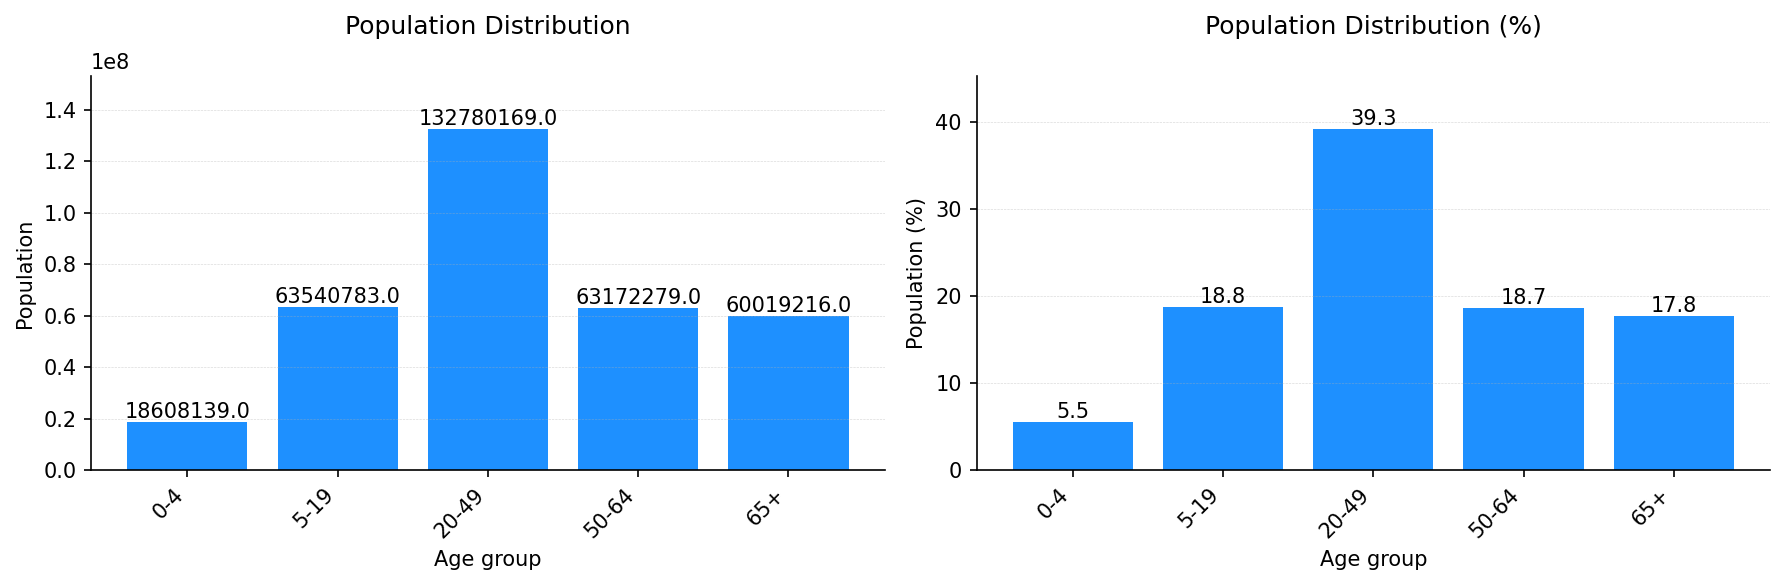

In [74]:
from epydemix.visualization import plot_contact_matrix, plot_population
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), dpi=150)

# Population pyramid
plot_population(population, ax=axes[0], title="Population Distribution")

# Population percentages
plot_population(population, ax=axes[1], title="Population Distribution (%)", show_perc=True)

plt.tight_layout()

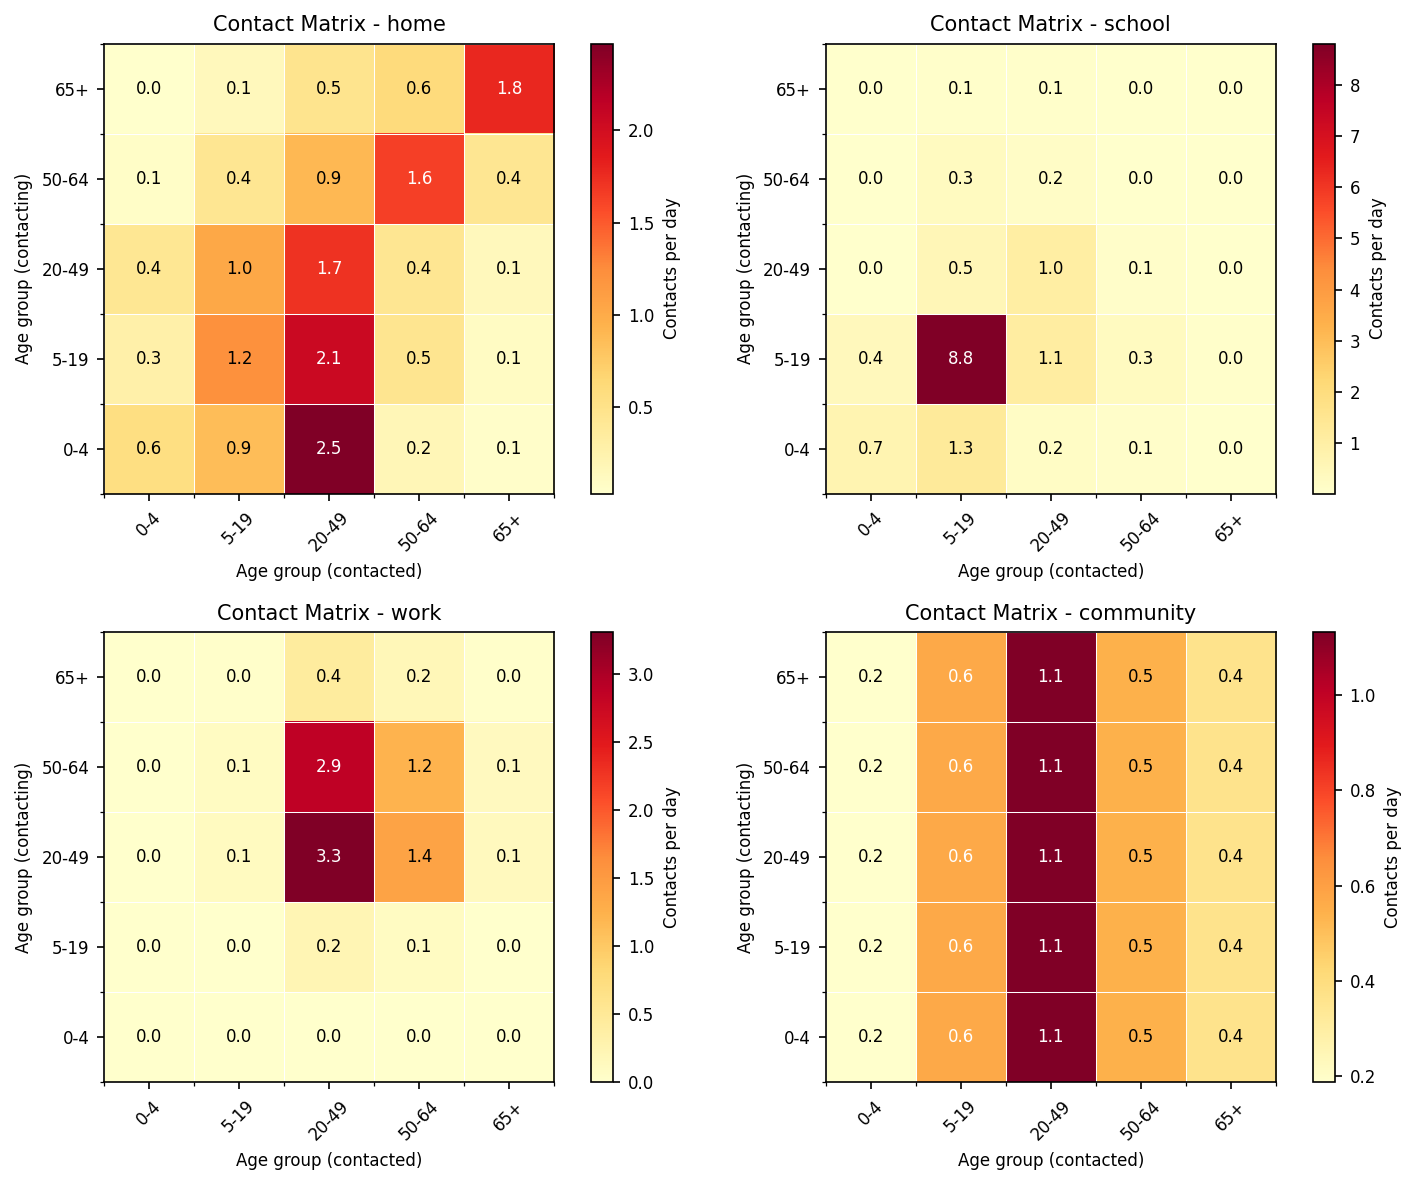

In [75]:
# Contact matrices by setting
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), dpi=150)

for ax, layer in zip(axes.flatten(), ["home", "school", "work", "community"]):
    plot_contact_matrix(population, layer, ax=ax, fontsize=8, show_values=True)

plt.tight_layout()

**Reading contact matrices:** Each cell $(i, j)$ shows the average daily contacts that a person in age group $i$ has with people in age group $j$. Notice how:
- **School** contacts are concentrated among children (5-19)
- **Work** contacts peak in working-age adults (20-64)
- **Home** contacts show intergenerational mixing
- **Community** contacts are more diffuse

### What is the Model $R_0$?

The reproduction number $R_0$ is the average number of people an infected person will infect. For the SEIR model on an age-structured population, it can be computed as:    

$$
R_0 = \frac{\beta}{\gamma} \rho(C)
$$

Where $\rho(C)$ is the spectral radius (i.e., the largest eigenvalue) of the contact matrix $C$, $\beta$ is the transmission rate, and $\gamma$ is the recovery rate. The spectral radius is a measure of the "intensity" of contacts in the population: higher values mean that there are more contacts, and therefore more opportunities for transmission. In other words, $R_0$ is the product of the average number of people an infected person will infect per unit of time and the average duration of the infectious period. In our case, $R_0$ can be computed as:




In [76]:
import numpy as np

# Get overall contact matrix as sum of individual matrices and compute spectral radius
C = np.sum(list(model.population.contact_matrices.values()), axis=0)
rho = np.linalg.eigvals(C).real.max()  

# Compute R0
R0 = model.parameters["beta"] / model.parameters["gamma"] * rho
print(f"R0: {R0:.2f}")

R0: 3.51


---
## 3. Running Simulations

Epydemix uses **stochastic chain-binomial** simulations. Each run produces a different trajectory due to randomness—we run many simulations to capture uncertainty.

Let's run simulations.

In [87]:
# Run 100 stochastic simulations
results = model.run_simulations(
    start_date="2026-01-01",
    end_date="2026-10-31",
    Nsim=25,
    percentage_in_agents=20 / population.Nk.sum()  # seed with 10 infected
)

### Visualizing Results

The `SimulationResults` object provides methods to extract compartment counts and transitions over time.

<Axes: title={'center': 'SEIR Epidemic Trajectory'}>

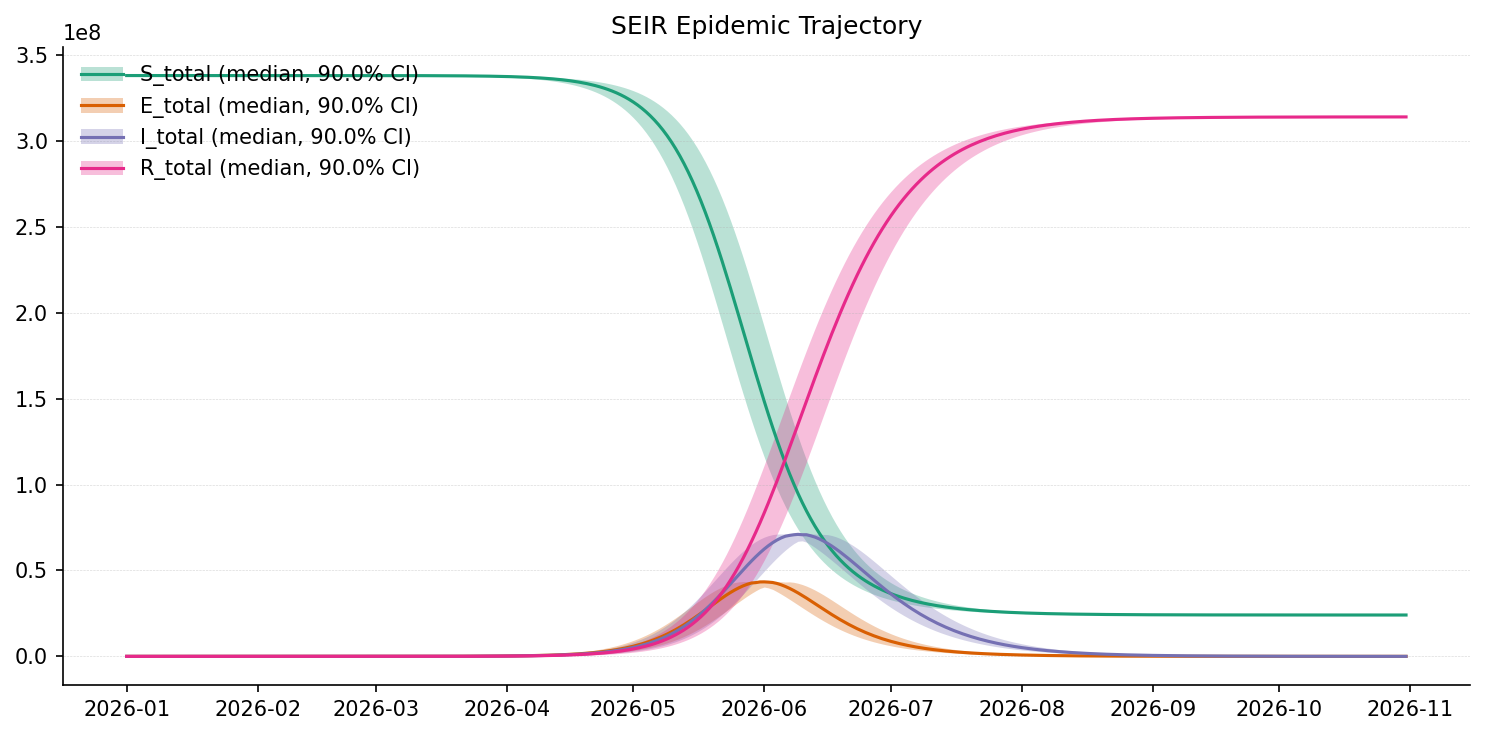

In [88]:
from epydemix.visualization import plot_quantiles

# Get quantiles (median, 25th, 75th percentiles) across simulations
df_quantiles = results.get_quantiles_compartments()

# Plot all compartments
fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
plot_quantiles(df_quantiles, columns=["S_total", "E_total", "I_total", "R_total"], 
               title="SEIR Epidemic Trajectory", ax=ax)

<Axes: title={'center': 'Infections by Age Group'}>

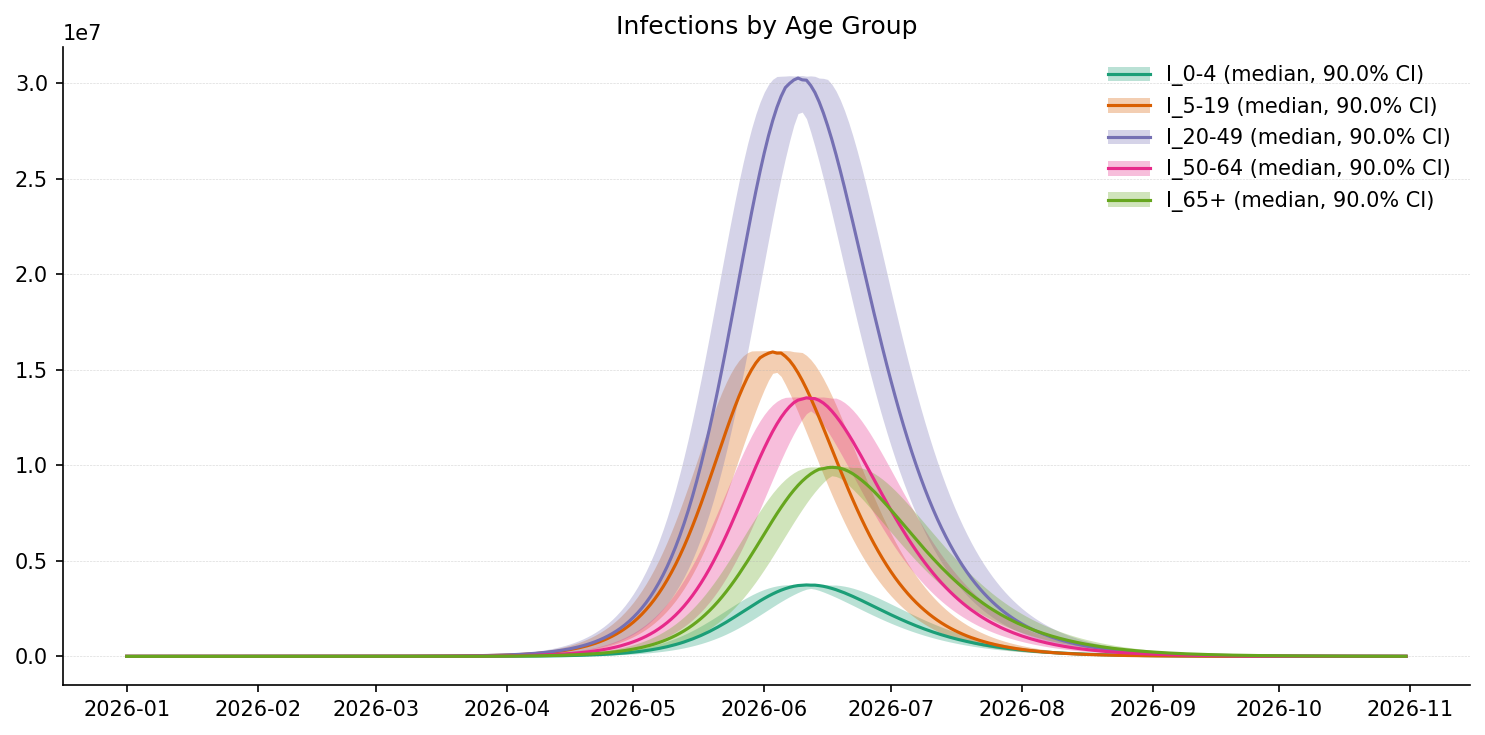

In [96]:
# Infections by age group
fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
plot_quantiles(df_quantiles, 
               columns=["I_0-4", "I_5-19", "I_20-49", "I_50-64", "I_65+"],
               title="Infections by Age Group", ax=ax, legend_loc="upper right")

<Axes: title={'center': 'Individual Simulation Trajectories (Infected)'}>

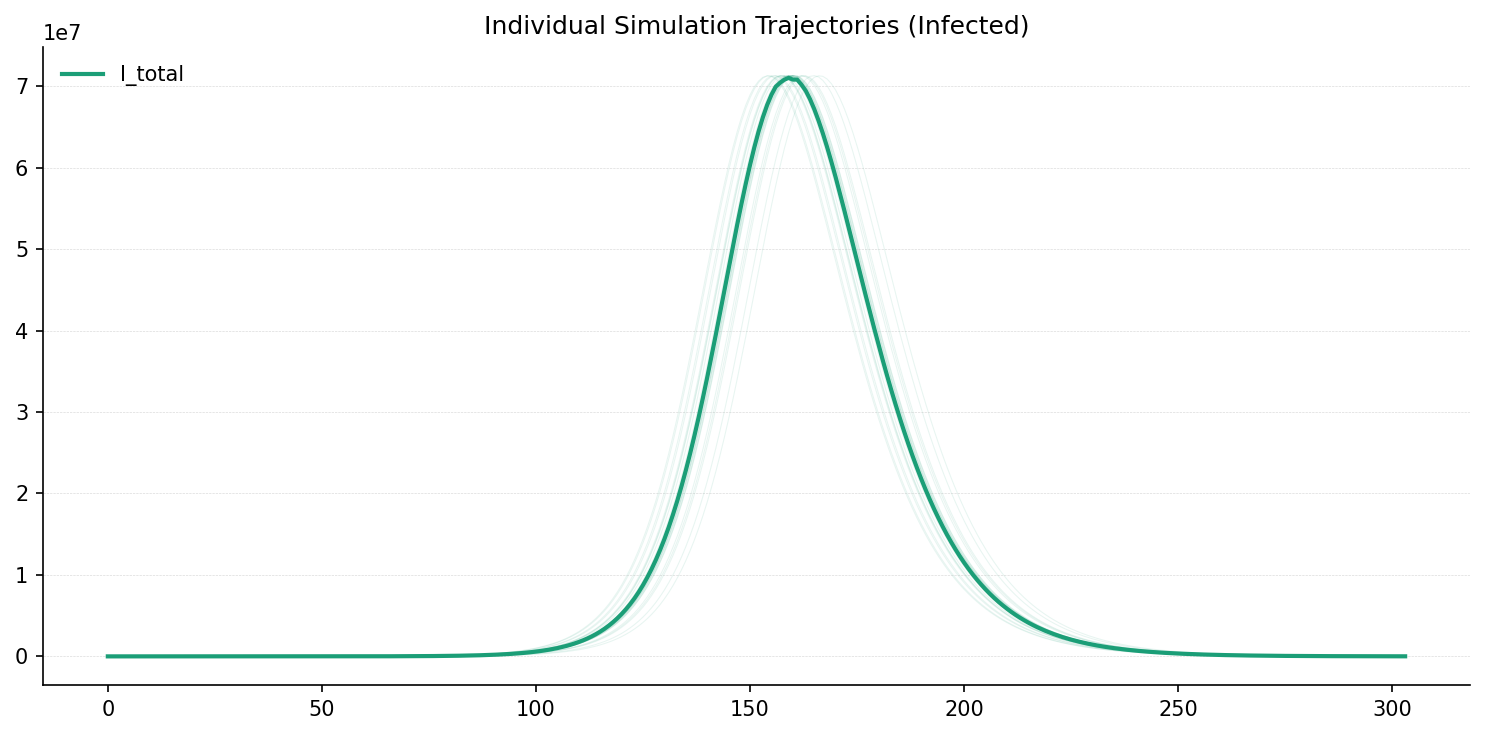

In [97]:
from epydemix.visualization import plot_trajectories

# Show individual simulation trajectories
trajectories = results.get_stacked_compartments()
fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
plot_trajectories(trajectories, columns=["I_total"], 
                  title="Individual Simulation Trajectories (Infected)", ax=ax)

---
## 4. Modeling Interventions

Non-pharmaceutical interventions (NPIs) reduce transmission by limiting contacts. Epydemix supports two approaches:

1. **`add_intervention`**: Reduce contacts in specific settings (school closure, work-from-home)
2. **`override_parameter`**: Modify transmission parameters directly (masking, social distancing)

Let's compare a baseline scenario to one with interventions.

In [106]:
# Create two identical SEIR models
def create_seir_model():
    m = EpiModel(name="SEIR", compartments=["S", "E", "I", "R"])
    m.add_transition(source="S", target="E", params=("beta", "I"), kind="mediated")
    m.add_transition(source="E", target="I", params="sigma", kind="spontaneous")
    m.add_transition(source="I", target="R", params="gamma", kind="spontaneous")
    m.add_parameter("beta", 0.025)
    m.add_parameter("sigma", 0.2)
    m.add_parameter("gamma", 0.1)
    m.set_population(population)
    return m

model_baseline = create_seir_model()
model_intervention = create_seir_model()

In [107]:
# Add interventions to one model

# School closure: 70% reduction in school contacts (Feb 1 - Apr 30)
model_intervention.add_intervention(
    layer_name="school",
    start_date="2026-02-01",
    end_date="2026-04-30",
    reduction_factor=0.3,  # 70% reduction
    name="school closure"
)

# Work-from-home: 50% reduction in work contacts (Feb 1 - Apr 30)
model_intervention.add_intervention(
    layer_name="work",
    start_date="2026-03-01",
    end_date="2026-06-30",
    reduction_factor=0.5,  # 50% reduction
    name="work from home"
)

### Visualizing Intervention Impact on Contacts

The **spectral radius** of the contact matrix is proportional to $R_0$. We can visualize how interventions reduce it over time.

<Axes: title={'center': 'Contact Pattern Intensity - Overall Layer'}, xlabel='Date', ylabel='Change in spectral radius (%)'>

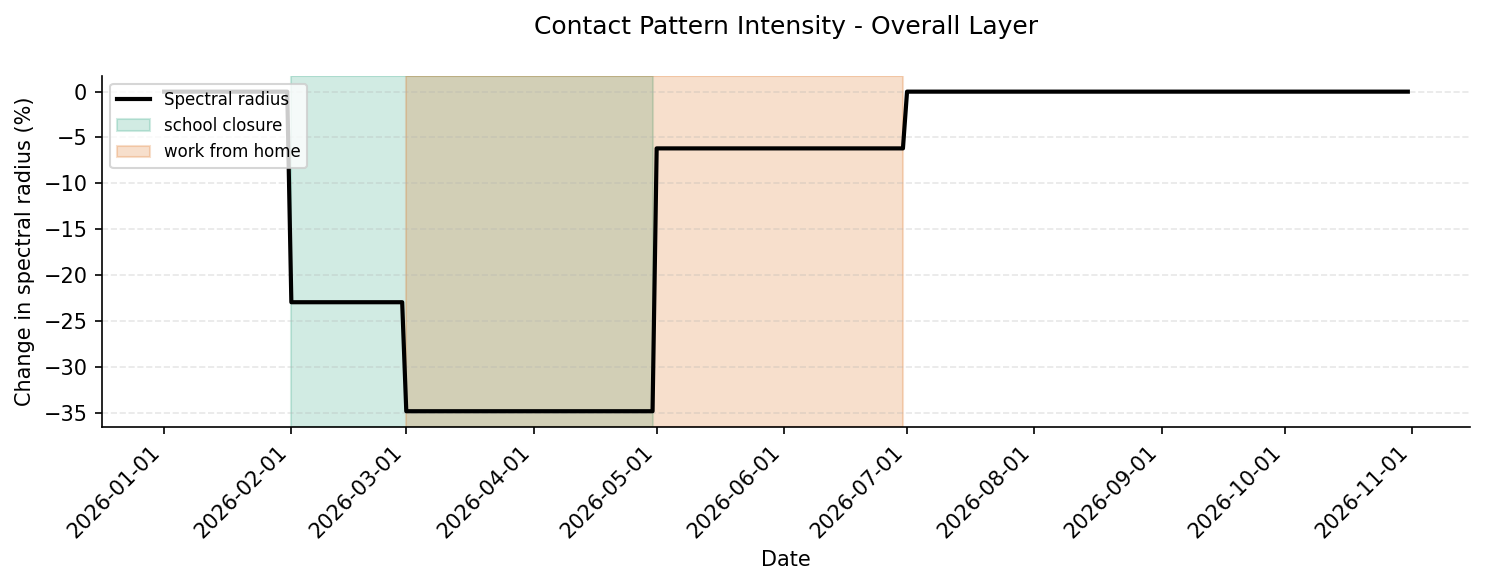

In [108]:
from epydemix.visualization import plot_spectral_radius
from epydemix.utils import compute_simulation_dates

# Compute contact reductions
simulation_dates = compute_simulation_dates("2026-01-01", "2026-10-31")
model_intervention.compute_contact_reductions(simulation_dates)

# Plot spectral radius change
fig, ax = plt.subplots(figsize=(10, 4), dpi=150)
plot_spectral_radius(model_intervention, show_perc=True, ax=ax)

### Comparing Scenarios

In [109]:
# Run both scenarios
sim_params = dict(
    start_date="2026-01-01",
    end_date="2026-10-31",
    Nsim=25,
    percentage_in_agents=20 / population.Nk.sum()
)

results_baseline = model_baseline.run_simulations(**sim_params)
results_intervention = model_intervention.run_simulations(**sim_params)

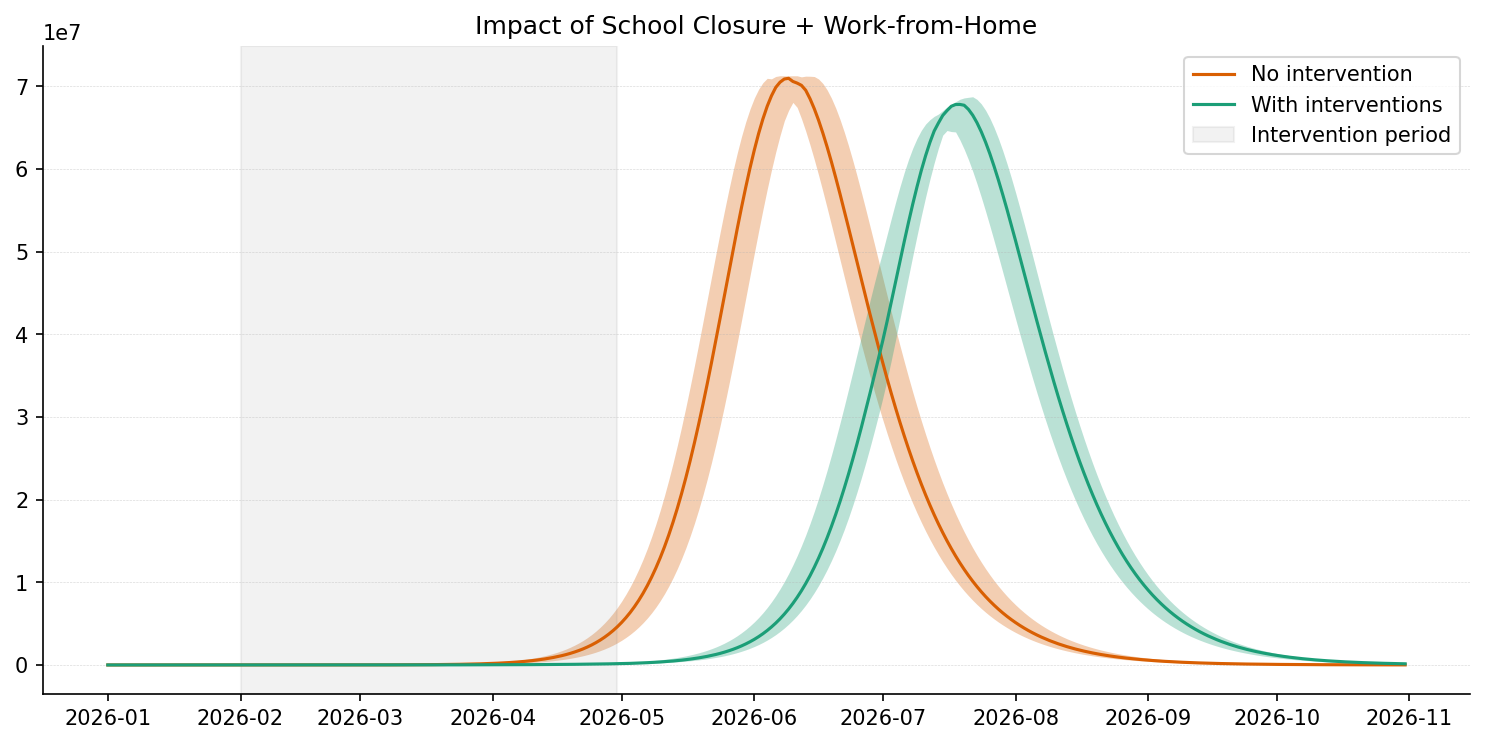

In [115]:
import seaborn as sns
colors = sns.color_palette("Dark2")

fig, ax = plt.subplots(figsize=(10, 5), dpi=150)

# Plot baseline
df_baseline = results_baseline.get_quantiles_compartments()
plot_quantiles(df_baseline, columns=["I_total"], colors=colors[1], 
               labels="No intervention", ax=ax)

# Plot intervention scenario
df_intervention = results_intervention.get_quantiles_compartments()
plot_quantiles(df_intervention, columns=["I_total"], colors=colors[0],
               labels="With interventions", ax=ax)

ax.set_title("Impact of School Closure + Work-from-Home")
ax.axvspan("2026-02-01", "2026-04-30", alpha=0.1, color="gray", label="Intervention period")
ax.legend()

### Quantifying Impact

Let's calculate the reduction in total infections and peak size.

In [112]:
import numpy as np

# Get full trajectories
traj_baseline = results_baseline.get_stacked_compartments()
traj_intervention = results_intervention.get_stacked_compartments()

# Total infections (final recovered count)
total_baseline = traj_baseline["R_total"][:, -1]
total_intervention = traj_intervention["R_total"][:, -1]
averted = (total_baseline - total_intervention) / total_baseline * 100

# Peak infections
peak_baseline = traj_baseline["I_total"].max(axis=1)
peak_intervention = traj_intervention["I_total"].max(axis=1)
peak_reduction = (peak_baseline - peak_intervention) / peak_baseline * 100

print(f"Infections averted: {np.median(averted):.1f}% (IQR: {np.percentile(averted, 25):.1f}–{np.percentile(averted, 75):.1f}%)")
print(f"Peak reduction: {np.median(peak_reduction):.1f}% (IQR: {np.percentile(peak_reduction, 25):.1f}–{np.percentile(peak_reduction, 75):.1f}%)")

Infections averted: 0.4% (IQR: 0.3–0.4%)
Peak reduction: 4.6% (IQR: 4.1–5.3%)


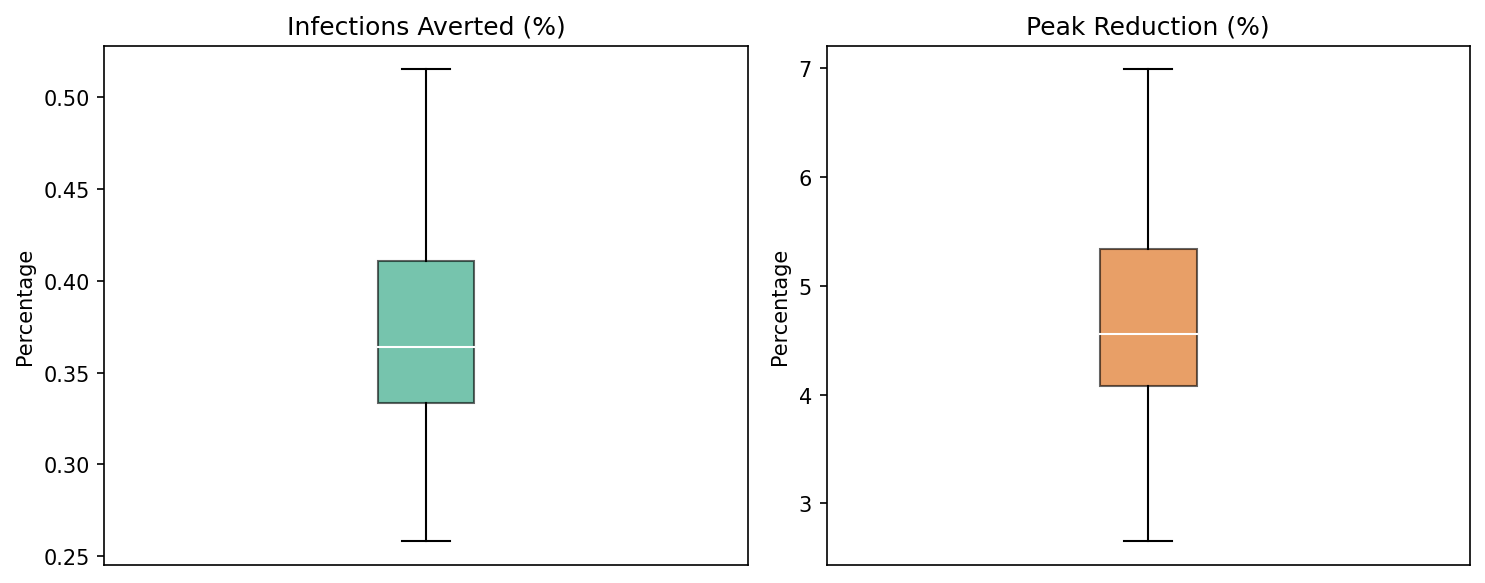

In [113]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=150)

axes[0].boxplot(averted, patch_artist=True,
                boxprops=dict(facecolor=colors[0], alpha=0.6),
                medianprops=dict(color="white"),
                showfliers=False)
axes[0].set_ylabel("Percentage")
axes[0].set_title("Infections Averted (%)")
axes[0].set_xticks([])

axes[1].boxplot(peak_reduction, patch_artist=True,
                boxprops=dict(facecolor=colors[1], alpha=0.6),
                medianprops=dict(color="white"),
                showfliers=False)
axes[1].set_ylabel("Percentage")
axes[1].set_title("Peak Reduction (%)")
axes[1].set_xticks([])

plt.tight_layout()

---
## 5. Exercises

Try these modifications to deepen your understanding:

1. **Change the geography**: Load a different population (e.g., `"Kenya"`, `"Brazil"`, `"Japan"`) and observe how contact patterns differ.

2. **Vary intervention timing**: What happens if interventions start earlier (day 15) vs. later (day 60)?

3. **Target specific age groups**: Use `override_parameter` to reduce transmission only in certain age groups.

4. **Add waning immunity**: Create an SEIRS model by adding an R→S transition with a slow rate.

In [ ]:
# Your code here


---
## Resources

- [Epydemix Documentation](https://epydemix.readthedocs.io/)
- [Full Tutorial Series](https://github.com/epistorm/epydemix/tree/main/tutorials)
- [Supported Geographies](https://github.com/epistorm/epydemix-data/blob/main/locations.csv)